In [1]:
import pandas as pd
import numpy as np
import regex
import os, sys

# USER INPUTS

In [2]:
"""Experiment name to prepend output files"""
EXPERIMENT = "sample"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-sample.csv"
"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100

# PRESETS AND SCRIPT

In [3]:
"""Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']

# for older versions/ formats
# SAMPLE = 'idx'
# QTAG = 'qtag'
# BARCODE = 'gtag'
# READS = 'reads'
# MCOUNTS = 'molecs'
# PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
# GROUPBY = ['idx']

In [4]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [5]:
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS):
    """Updates percent molec counters for sample"""
    total = float(df[mcounts].values.sum()) / 100.
    df[percent_mcounts] = df[mcounts].apply(lambda x: x/total)
    df = df.sort_values(by=mcounts, ascending=False)
    return df

In [6]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    csv = pd.read_csv(filtered_file, sep=',')
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [7]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [8]:
def threshold(group, reps_remaining, thresh_val, thresh_i,
             percent_mcounts=PERCENT_MCOUNTS, mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging [0,len(group))

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        # line add 2016-10-12 to pre-sort values
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        group = calculate_percent_molecs(group)
        calc_threshold_i = calculate_threshold(group[mcounts].values)
        if calc_threshold_i < 0:
            print "Insufficient number of reads in sample. Skipping."
        else:
            new_thresh_i = min(calc_threshold_i, len(group)-1)
            new_thresh_val = group[percent_mcounts].values[new_thresh_i]
            # if reached steady state
            if new_thresh_val == thresh_val:
                # get rid of any "padding" barcodes (see eliminate_oneoffs fn)
                # line added 2016-10-12 to remove barcodes that didn't pass threshold
                passed_temp = group.loc[(group.is_padding==False) & (group[percent_mcounts]>=new_thresh_val)]
                passed = calculate_percent_molecs(passed_temp)
                passed.reset_index(inplace=True,drop=True)
                sys.stdout.write('Thresholded.\n')
                return passed
            # recursively clean and re-threshold
            else:
                # clean up group by eliminating one-offs
                group = calculate_percent_molecs(group)
                cleaned = eliminate_oneoffs(group,new_thresh_val)
                cleaned.reset_index(inplace=True,drop=True)
                # recurse with cleaned df and new threshold values
                return threshold(cleaned, reps_remaining-1, new_thresh_val, 
                                 new_thresh_i, percent_mcounts=percent_mcounts, 
                                 mcounts=mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [9]:
# STEP 2: CALCULATE THRESHOLD via. CONCAVITY


def calculate_threshold(y):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            yield float(w[1]-w[0])/(w[0]+w[1])*2
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]         
    
    y_temp = sorted(y, reverse=True)
    # left and right padding to cover all array vals in derivations
    yarray = np.concatenate([ [y_temp[0]], y_temp, [1] ])
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    second_windows = rolling_window(first_derivs)
    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    thresh_i = np.argmin(second_derivs)+1

    return thresh_i

In [10]:
def eliminate_oneoffs(group, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS, 
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
    """
    group.loc[:,'delete'] = group[mcounts].apply(lambda _: False)
    group.loc[:,'is_padding'] = group[mcounts].apply(lambda _: False)
    counter = 0
    # add capability to check other parameters, i.e. qtag
    for majorI, majorRow in group.loc[group[percent_mcounts] > thresh_val].iterrows():
        # if it has not yet been tested
        if majorRow.delete == False:
            subgroup = group[counter+1:].loc[(group.delete==False)]
            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for minorI, minorRow in subgroup.iterrows():
                query = regex.search("(%s){s<=1}" % majorRow[barcode],
                                     minorRow[barcode])
                if query:
                    group.loc[minorI,'delete'] = True
        counter+=1
        
    # select barcodes which pass, ie. are not eliminated
    output = group.loc[(group.delete==False) & (group[percent_mcounts] >= thresh_val)]

    # if requested, adds a right pad  
    # line added 2016-10-12: combine two conditions: ensure that 
    # no null rows get added if all barcodes are accepted
    if pad==True and len(group) != len(group.delete==False):
        deletes = group.loc[(group.delete==True) & (group[percent_mcounts]<thresh_val)][mcounts]
        max_i = deletes.idxmax()
        output.append(group.loc[max_i,:])
        output.loc[max_i,['delete', 'is_padding']] = [False, True]
    return output
            

In [11]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("Sample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        group = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') 
                          & (group[mcounts] > min_mcount)
                          & (group[reads] > min_reads)]
        result = threshold(group, 20, -1, len(group)+2)
        passed.append(result)
        sys.stdout.flush()
        counter += 1
    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.drop(['delete','is_padding'], axis=1, inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [12]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [13]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [14]:
def apply_passed_data(filtered, passed, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row[percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row['passed_threshold'] = True
        return row

    passed_indexed = passed.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered['passed_threshold'] = False
    filtered[percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

## EXPERIMENTAL

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.fftpack


In [16]:
filtered = load_data(FILTERED_FILEPATH)
mouse = load_data('../output/filtered-mouse_sample.csv')
midx, mdf = mouse[8]

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
"""THIS THIS THIS! -- converting to calculate threshold function 
to integrate into threshold algo """

"""************** HOW DO I EXPLAIN spectrum.max()/5????"""

# use this for thresholding
def calculate_threshold(y):
    """calculate_threshold(y, min_reads=1000, N=100)
    
        Calculates threshold using discrete Fournier transformation to smooth,
        followed by inverse to recover initial wave

        DFT used as the curve does exhibit wave-like properties.

        Input:
            y: np.array() containing count values
            min_reads (int, optional): minimum total reads in index required (as QC)

        Returns:
            index of threshold value (int) in y

        Note: DFT process is based on answer provided by user Hooked (249341) at
        http://stackoverflow.com/questions/20618804/
    """
    y = f2.mcountsPF.values
    if sum(y) < 1000:
        print "insufficient number of reads"
        return -1
    else:
        x = range(1,len(y)+1) 
        
        # DFT starts here
        w = scipy.fftpack.rfft(y)
        f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
        spectrum = w**2
        cutoff_val = np.percentile(spectrum, 5)
        cutoff_idx = spectrum < (spectrum.max()/5)
        
        w2 = w.copy()
        w2[cutoff_idx] = 0
        y2 = scipy.fftpack.irfft(w2)
        # DFT ends here
        
        # derivative of inverse transformed data
        # id threshold (i.e. loc of cutoff)
        y2d  =y2[1:]-y2[:-1]
        t = np.argmin(y2d[:-1])+1
        
        """THIS STUFF FOR PLOTTING"""
        y2plot = np.log10(y2.copy())
        y2plot[np.isnan(y2plot)==True] = 0
        
        fi, ax1 = plt.subplots()
#         fi, (ax1,ax2) = plt.subplots(2)
        ax1.plot(np.log10(range(1,len(f2)+1)),np.log10(f2.mcountsPF))
        ax1.plot(np.log10(range(1,len(y2plot)+1)),y2plot)
        tspan = np.log10([np.min(y),np.max(y)])
        ax1.plot(np.log10([t,t]),tspan,lw=2, c='green')
        ax1.set_title(f1+" "+str(t))
        
#         ax2.plot(range(1,len(y2d)+1), y2d, c='green')
#         tspan2 = [np.min(y2d),np.max(y2d)]
#         ax2.plot([t,t],tspan2,lw=4, c='green')

        


66705 1
22680 1
8008 1
2512 1


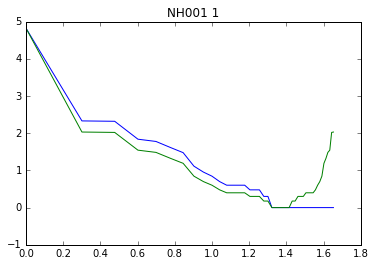

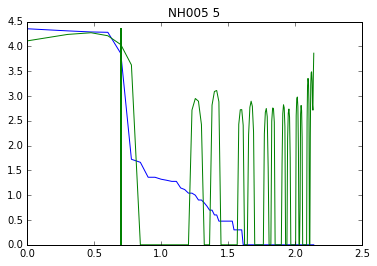

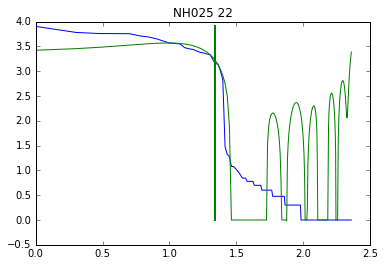

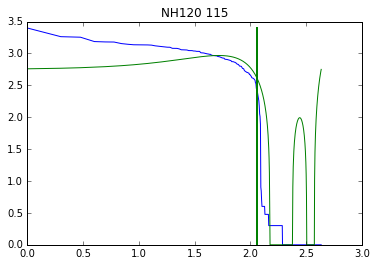

In [554]:
"""THIS THIS THIS!"""
ts_fft_w = []

for f1, f2 in filtered:
# for f1, f2 in mouse:
    N = 100
    y = f2.mcountsPF.values
    if sum(y) > 1000:
        x = range(1,len(y)+1)      
        w = scipy.fftpack.rfft(y)
        f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
        spectrum = w**2
        # find value of element 2 std below mean
        # using log10 spectrum values; frequencies are
        # in a gaussian-like distribution
        logspec = np.log10(spectrum)
#         cutoff_val = 10**abs(np.mean(logspec) - np.median(logspec))*2
        cutoff_val = spectrum.max()/5
        print abs(y).max(), abs(y).min()
#         cutoff_val = spectrum.max()/(10**abs(np.mean(logspec) - np.median(logspec))^2)

        cutoff_idx = spectrum < cutoff_val
        w2 = w.copy()
        w2[cutoff_idx] = 0
        y2 = scipy.fftpack.irfft(w2)
        
        # derivative of inverse transformed data
        # id threshold (i.e. loc of cutoff)
        y2d  =y2[1:]-y2[:-1]
        t = np.argmin(y2d[:-1])+1
        
        """THIS STUFF FOR PLOTTING"""
        y2plot = np.log10(y2.copy())
        y2plot[np.isnan(y2plot)==True] = 0
        
        fi, ax1 = plt.subplots()
#         fi, (ax1,ax2) = plt.subplots(2)
        ax1.plot(np.log10(range(1,len(f2)+1)),np.log10(f2.mcountsPF))
        ax1.plot(np.log10(range(1,len(y2plot)+1)),y2plot)
        tspan = np.log10([np.min(y),np.max(y)])
        ax1.plot(np.log10([t,t]),tspan,lw=2, c='green')
        ax1.set_title(f1+" "+str(t))
        
#         ax2.plot(range(1,len(y2d)+1), y2d, c='green')
#         tspan2 = [np.min(y2d),np.max(y2d)]
#         ax2.plot([t,t],tspan2,lw=4, c='green')

        

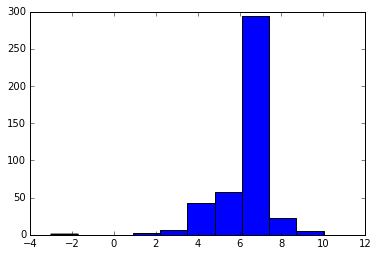

In [881]:
y2hist_n, y2hist_b, y2hist_f = plt.hist(np.log10(spectrum))
splitidx = np.max(np.where(y2hist_n==np.min(y2hist_n)))
splitval = y2hist_b[splitidx]
# 10**(np.mean(np.log10(spectrum)) - np.std(np.log10(spectrum))*2)


### APPENDIX 

In [673]:
[['rraw',[13905,6687,624,411,383,310,205,192,169,168,161]]]


[['rraw', [13905, 6687, 624, 411, 383, 310, 205, 192, 169, 168, 161]]]

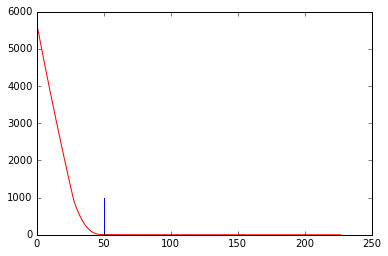

In [175]:
"""LOWESS"""

yl = statsm.lowess(y, x, frac=0.25)
f, ax = plt.subplots()
plt.plot(x,[i[1] for i in yl], c='red')
plt.plot([50,50],[1,1000])
# , frac=0.6666666666666666, it=3, delta=0.0, is_sorted=False, missing='drop', return_sorted=True)


for idx, ydf in filtered:
    y = np.log10(ydf.mcountsPF.values)
    x = np.log10(range(len(y)))
    lowess = sm.nonparametric.lowess(y, x, frac=0.6)

    plt.plot(x, y, '+')
    plt.plot(lowess[:, 0], lowess[:, 1])
    plt.show()


In [347]:
"""elimination before thresholding"""
f2o = eliminate_oneoffs(f2,np.max(yd))
print len(f2o)
calculate_threshold(f2o.mcountsPF)

plt.plot(range(len(f2o)), np.log10(f2o.mcountsPF))
f2.loc[:,'passed'] = f2.apply(lambda x: True if (x.qtag,x.barcode) in f2o[['qtag','barcode']] else False, axis=1)
len(f2.loc[f2.mcountsPF >= min(f2o.mcountsPF)])

plt.plot(range(len(f2)),np.log10(f2.mcountsPF))
plt.plot([57,57],[0,3])

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Thresholded.
Thresholded.
Thresholded.
Thresholded.


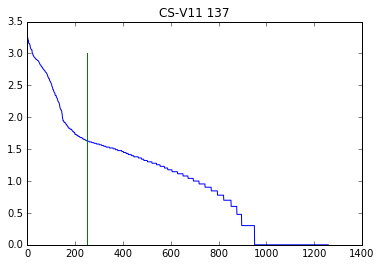

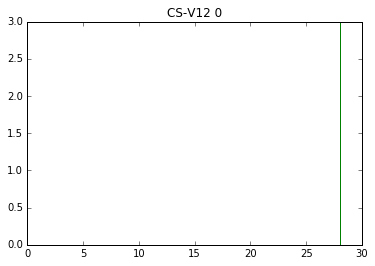

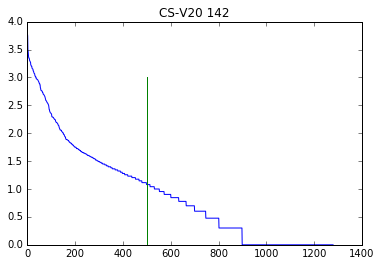

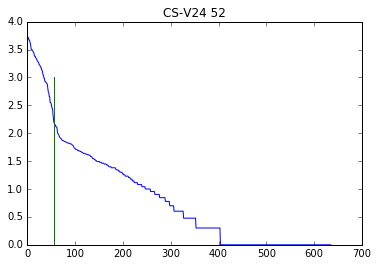

In [399]:
"""Recalculate threshold after running threshold """
for f1, f2 in mouse[:4]:
    thr_init = threshold(f2, 20, len(f2), -1)
    y_init = thr_init.mcountsPF.values
    thr_fin = calculate_threshold(y_init[:-1]*(y_init[:-1]-y_init[1:]))-1
    f2_line = len(f2.loc[f2.mcountsPF>=y_init[thr_fin]])
    f, ax = plt.subplots()
#     ax1.plot(np.log10(range(1,len(yd)+1)),np.log10(yd))
    ax.plot(range(len(f2.mcountsPF)),np.log10(f2.mcountsPF))
    ax.plot([f2_line,f2_line],[0,3])

    ax.set_title(f1+" "+str(thr_fin))

In [535]:
# import scipy.signal
# import statsmodels.api as sm
# import scipy.interpolate

In [605]:
"""1D interpolation; from stackoverflow"""
y = ydf.mcountsPF.values
logx = np.log10(range(1,len(y)+1))
logy = np.log10(y)
lin_interp = scipy.interpolate.interp1d(logx, logy)
log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
yinter = log_interp(logy)
plt.plot(x,y)
plt.plot(x,yinter)

NH120


ValueError: A value in x_new is above the interpolation range.

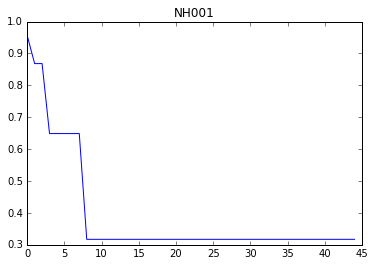

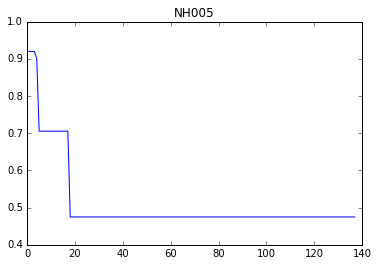

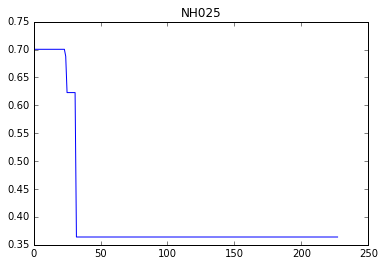

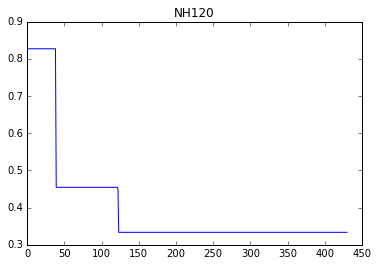

In [583]:
"""Scipy KDE multivariate cdf calc"""
for idx, ydf in filtered:
    y = np.log10(ydf.mcountsPF.values)
    kde = sm.nonparametric.KDEMultivariate(data=y, var_type='u')
    f, ax = plt.subplots()
    plt.plot(range(len(y)),kde.cdf())
    ax.set_title(idx)

In [ ]:
 """DFT code is from http://stackoverflow.com/questions/20618804/"""

""" [1] w = scipy.fftpack.rfft(y)

    Discrete Fourier transform of a real sequence
    rfft(x, n=None, axis=-1, overwrite_x=False); w= transformed y

    returns 
    [y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2))]              if n is even
          [y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2)),Im(y(n/2))]   if n is odd
     y(j) = sum[k=0..n-1] x[k] * exp(-sqrt(-1)*j*k*2*pi/n)
          j = 0..n-1
""" 
"""[2] f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
        
    DFT sample frequencies (for usage with rfft, irfft)
    rfftfreq(n, d=1.0)
    n = window (usually size(w))
    d = sample space
    returns
    f = [0,1,1,2,2,...,n/2-1,n/2-1,n/2]/(d*n)   if n is even
      f = [0,1,1,2,2,...,n/2-1,n/2-1,n/2,n/2]/(d*n)   if n is odd

      where 
      The array of length `n`, containing the sample frequencies
    """



"""[2] y2 = scipy.fftpack.irfft(w2)

    irfft(x, n=None, axis=-1, overwrite_x=False)

    Return inverse discrete Fourier transform of real sequence x.

    The contents of `x` are interpreted as the output of the `rfft`
    function

    x : array_like
        Transformed data to invert.
    n : int, optional
        Length of the inverse Fourier transform.
        If n < x.shape[axis], x is truncated.
        If n > x.shape[axis], x is zero-padded.
        The default results in n = x.shape[axis].

        fn is similar to Inverse Fournier Transformation; 
        recovers function from FT: "statement is like if we know all
        frequency and phase information about a wave, then we may 
        reconstruct the original wave precisely". aka Fournier 
        integral theorem.
"""

## Trying Poisson fitting to calculate FFT filter threshiold

In [123]:
import scipy.optimize
import scipy.misc

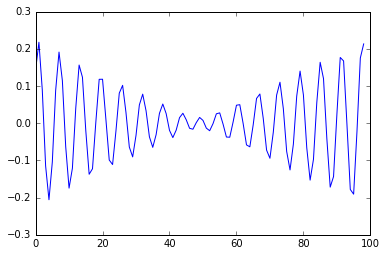

In [522]:
x = np.linspace(0,100,100)
y = np.sin(x)
wsin = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
spectrum = wsin**2
# cutoff_val = np.percentile(spectrum, 5)
cutoff_idx = spectrum < (spectrum.max()/5)
cutoff_idx = spectrum > np.mean(spectrum)
w2 = wsin.copy()
w2[cutoff_idx] = 0
y2 = scipy.fftpack.irfft(w2)

y2d = y2[1:]-y2[:-1]
plt.plot(range(len(y2d)),y2d)

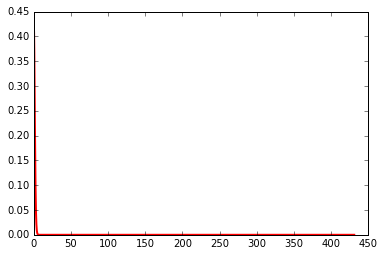

In [594]:
# entries, bin_edges, patches = plt.hist(spectrum, normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/scipy.misc.factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = scipy.optimize.curve_fit(poisson, range(len(spectrum)), spectrum) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 431, 100000)
f, ax = plt.subplots()
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
# plt.plot([xv,xv],[0,0.5])
plt.show()

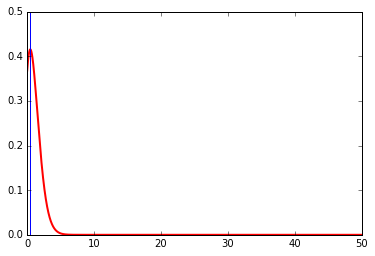

In [595]:
pmaxi = np.argmax(poisson(x_plot, *parameters))/100000.*431
ax.plot([pmaxi,pmaxi],[0,.5])
ax.set_xlim(0,50)
f

In [644]:
"""Helper to wrangl;e poisson fit data"""
def get_fit_results(pois_model):
    res = pois_model.fit()
    table1 = np.concatenate(res.summary().tables[0].data)
    i=0
    entries=[]
    while i < len(table1):
        t1a, t1b = table1[i].strip().strip(":"), table1[i+1].strip().strip(":")
        if len(t1a) > 0:
            if t1b == 'True' or t1b == 'False':
                t1b = bool(t1b)
            else:
                try:
                    t1b = float(t1b)
                except:
                    pass
            entries.append([t1a,t1b])
        i+=2

    table2 = np.array(res.summary().tables[1].data).T[1:]
    i = 0
    for row in table2:
        ra, rb = [cell.strip().strip(":") for cell in row]
        rb = np.array(rb.split(" "))
        rb = list(rb[rb!=''])
        for i in range(len(rb)):
            if rb[i] in ['True','False']: 
                rb[i] = bool(rb[i])
            else:
                try: 
                    rb[i] = float(rb[i])
                except:
                    pass
        rb = rb[0] if len(rb) < 2 else rb
        entries.append([ra, rb])
    entries_df = pd.DataFrame(entries)
    entries_df.set_index(0, inplace=True)
    entries_df.index.name = None
    entries_df.columns = ['value']
    return entries_df

In [218]:
import statsmodels.discrete.discrete_model

Optimization terminated successfully.
         Current function value: 4.367986
         Iterations 10


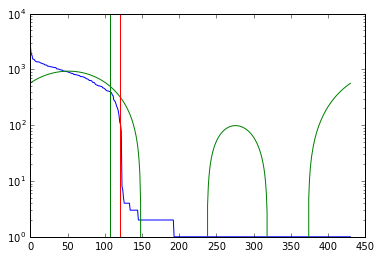

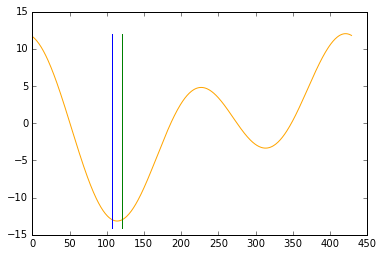

In [652]:
"""Using poisson results to calc cutoff.....doesn't work really >.< - test"""

w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
spectrum = w**2

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/scipy.misc.factorial(k)) * np.exp(-lamb)

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, len(spectrum), 100000)
f, ax = plt.subplots()



# use log to be able to fit w poisson distribution
# threshold relationship is relative so log doesn't matter
poiss = statsmodels.discrete.discrete_model.Poisson(np.log10(spectrum), 
                                                    range(len(spectrum)))
res = get_fit_results(poiss)
cutoff_val = spectrum.max()*res.loc['z','value']*res.loc['coef','value']/2
cutoff_idx = spectrum < cutoff_val
w2 = w.copy()
w2[cutoff_idx] = 0

y2 = scipy.fftpack.irfft(w2)
y2d  =y2[1:]-y2[:-1]
t = np.argmin(y2d) + 1
plt.plot(range(len(y)),y)
plt.plot(range(len(y2)),y2, c='green')
# plt.plot(range(len(y2d)),y2d, c='orange')

plt.plot([107,107],[1,10000])
plt.plot([120,120],[1,10000])

plt.gca().set_yscale('log')

f, ax = plt.subplots()
plt.plot(range(len(y2d)),y2d, c='orange')

plt.plot([107,107],[np.min(y2d)-1, np.max(y2d)])
plt.plot([120,120],[np.min(y2d)-1, np.max(y2d)])


Optimization terminated successfully.
         Current function value: 5.393995
         Iterations 11
Optimization terminated successfully.
         Current function value: 5.502045
         Iterations 12
Optimization terminated successfully.
         Current function value: 5.023148
         Iterations 11
Optimization terminated successfully.
         Current function value: 4.367986
         Iterations 10


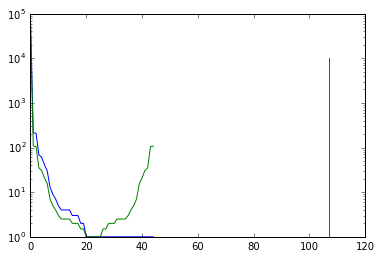

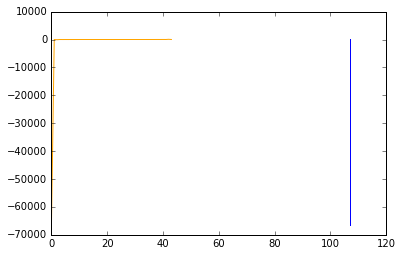

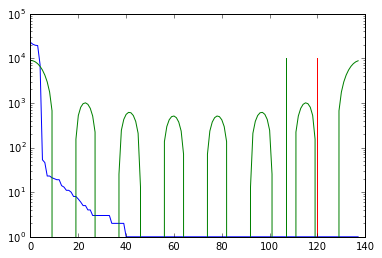

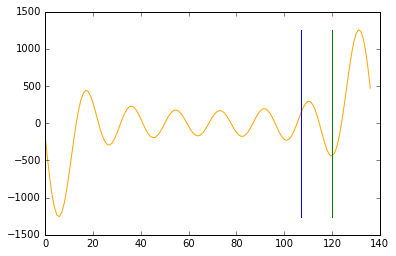

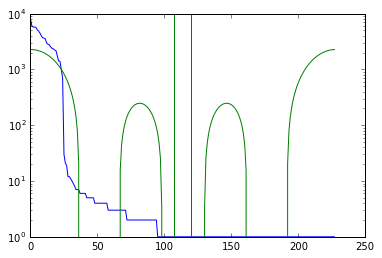

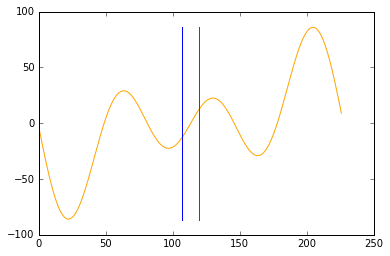

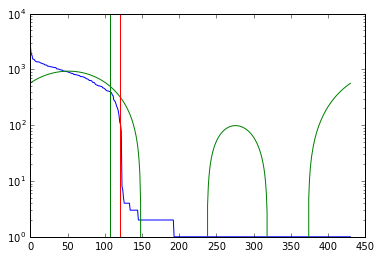

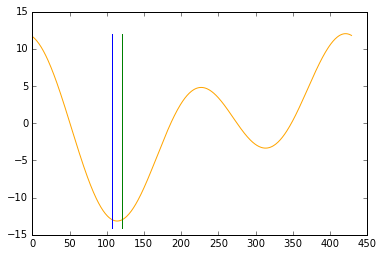

In [653]:
"""Using poisson results to calc cutoff.....doesn't work really >.<"""
for f1, f2 in filtered:
# for f1, f2 in mouse:
    y = f2.mcountsPF.values
    if sum(y) > 1000:
        w = scipy.fftpack.rfft(y)
        f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
        spectrum = w**2

        # poisson function, parameter lamb is the fit parameter
        def poisson(k, lamb):
            return (lamb**k/scipy.misc.factorial(k)) * np.exp(-lamb)

        # plot poisson-deviation with fitted parameter
        x_plot = np.linspace(0, len(spectrum), 100000)
        f, ax = plt.subplots()



        # use log to be able to fit w poisson distribution
        # threshold relationship is relative so log doesn't matter
        poiss = statsmodels.discrete.discrete_model.Poisson(np.log10(spectrum), 
                                                            range(len(spectrum)))
        res = get_fit_results(poiss)
        cutoff_val = spectrum.max()*res.loc['z','value']*res.loc['coef','value']/2
        cutoff_idx = spectrum < cutoff_val
        w2 = w.copy()
        w2[cutoff_idx] = 0

        y2 = scipy.fftpack.irfft(w2)
        y2d  =y2[1:]-y2[:-1]
        t = np.argmin(y2d) + 1
        plt.plot(range(len(y)),y)
        plt.plot(range(len(y2)),y2, c='green')
        # plt.plot(range(len(y2d)),y2d, c='orange')

        plt.plot([107,107],[1,10000])
        plt.plot([120,120],[1,10000])

        plt.gca().set_yscale('log')

        f, ax = plt.subplots()
        plt.plot(range(len(y2d)),y2d, c='orange')

        plt.plot([107,107],[np.min(y2d)-1, np.max(y2d)])
        plt.plot([120,120],[np.min(y2d)-1, np.max(y2d)])
